# WRF Precip and ET for specific year
- compare to billy barr precipitation and snotel precipitation to WRF grid cell output within the ER
- get a map of these sites and compare the grid cell values to monthly climatology
- Look at bar chart of 2016 SWE from ASO + non-snow precip - ET(WRF) - GW_level SM

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from soslib import funcs
from metpy.units import units
import metpy.calc as calc
import pandas as pd
import rasterio
import rioxarray
import nctoolkit as nctk
from dataretrieval import nwis 
import datetime as dt

nctoolkit is using Climate Data Operators version 2.1.0


In [93]:
bb_climatology = pd.read_csv('../data/billy_barr_monthly_avg.csv',sep='\t')
bb_climatology[bb_climatology==" "] = np.nan
bb_climatology['WY'] = [int(str(year)[0:2]+str(year)[4:]) for year in bb_climatology['Year']]
bb_climatology['water_cm'] = bb_climatology['water_cm'].astype(float)
dates = pd.to_datetime([f"{bb_climatology.loc[i,'WY']}-{bb_climatology.loc[i,'Month']}-01" for i in bb_climatology.index], format='%Y-%m-%d')
date_list=[]

for i,date in enumerate(dates):
    if date.year == 1900:
        date = dt.date(2000,date.month,date.day)
    if date.month in [9,10,11,12]:
        date = dt.date(date.year-1,date.month,date.day)
    else:
        date = dt.date(date.year,date.month,date.day)
    date_list.append(date)
bb_climatology.index=date_list
bb_climatology = bb_climatology.drop(['Month', 'Year'], axis=1)
for col in bb_climatology:
    bb_climatology[col] = bb_climatology[col].astype(float)

bb_snowfall = pd.read_csv('../data/billy_barr_snowfall.csv', sep='\s+')
bb_snowfall = bb_snowfall.set_index('WY')


<AxesSubplot: >

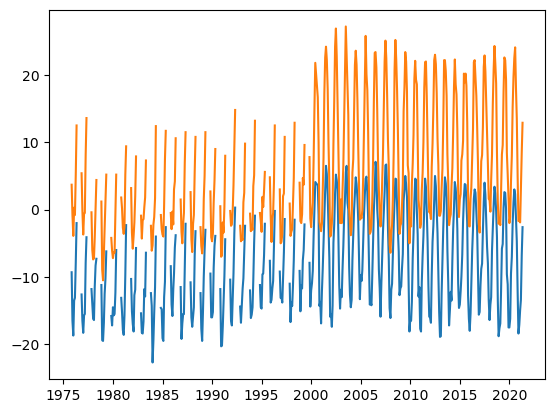

In [94]:
bb_climatology['Tmax'].plot()
bb_climatology['Tmin'].plot()

In [29]:
bb_monthly_precip = pd.read_csv('../data/billy_barr_total_monthly_P.csv', sep='\s+')
bb_monthly_precip = bb_monthly_precip.replace(-9999.,np.nan)
bb_monthly_precip = bb_monthly_precip.set_index('WY')
bb_monthly_precip

,Sept,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,June,July,Aug
WY,,,,,,,,,,,,
1976,NaN,NaN,3.53,2.34,2.95,6.64,3.20,1.77,0.42,NaN,NaN,NaN
1977,NaN,NaN,1.02,0.35,1.87,2.01,2.39,2.49,1.01,NaN,NaN,NaN
1978,NaN,NaN,3.07,5.98,4.93,4.64,7.16,2.58,1.63,NaN,NaN,NaN
1979,NaN,NaN,2.48,8.63,7.52,3.64,3.76,1.20,4.41,NaN,NaN,NaN
1980,NaN,NaN,4.52,1.18,10.67,8.61,5.59,2.13,2.83,NaN,NaN,NaN
1981,NaN,NaN,1.35,1.60,0.92,1.54,3.46,1.75,4.20,NaN,NaN,NaN
1982,NaN,NaN,1.66,4.90,6.32,2.17,7.43,2.36,1.75,NaN,NaN,NaN
1983,NaN,NaN,4.97,1.60,1.21,3.57,5.62,4.14,4.05,NaN,NaN,NaN
1984,NaN,NaN,6.46,12.10,1.03,1.74,4.02,3.99,2.89,NaN,NaN,NaN


In [15]:
er_sntl_data = xr.open_dataset('../../../../../storage/dlhogan/sos/data/east_river_sntl_20220930.nc')

In [24]:
er_sntl_data

<xarray.Dataset>
Dimensions:   (Date: 15554, Location: 3)
Coordinates:
  * Date      (Date) datetime64[ns] 1980-03-01 1980-03-02 ... 2022-09-30
  * Location  (Location) object 'Butte_380:CO:SNTL' ... 'SchofieldPass_737:CO...
    WY        (Date) int64 ...
Data variables:
    SMS       (Location, Date) float64 ...
    TAVG      (Location, Date) float64 ...
    SNWD      (Location, Date) float64 ...
    WTEQ      (Location, Date) float64 ...
    PREC      (Location, Date) float64 ...

In [83]:
snow_wteq_daily = er_sntl_data.sel(Location='Butte_380:CO:SNTL').where(er_sntl_data.WY==2018)['WTEQ']

snow_on_date = snow_wteq_daily.where(snow_wteq_daily>0).dropna(dim='Date').to_dataframe().index[0]
snow_off_date = snow_wteq_daily.sel(Date=slice('2018-01-01','2018-09-30')).where((snow_wteq_daily==0)).idxmin().values

In [55]:
wy2018_wrf_ds = xr.open_mfdataset('../../../../../storage/dlhogan/sos/data/WY2018/*.nc')

In [56]:
Lv = 2.501e6 # J kg-1
Ls = 2.834e6 # J kg-1

In [78]:
below_freezing_mask = ((wy2018_wrf_ds.where(wy2018_wrf_ds.EAST_MASK==True)['T2'] <= 273.15) &
                      (wy2018_wrf_ds.where(wy2018_wrf_ds.EAST_MASK==True).XTIME >= snow_on_date) & 
                      (wy2018_wrf_ds.where(wy2018_wrf_ds.EAST_MASK==True).XTIME < snow_off_date) ) 

above_freezing_mask = ((wy2018_wrf_ds.where(wy2018_wrf_ds.EAST_MASK==True)['T2'] > 273.15) &
                      (wy2018_wrf_ds.where(wy2018_wrf_ds.EAST_MASK==True).XTIME < snow_on_date) | 
                      (wy2018_wrf_ds.where(wy2018_wrf_ds.EAST_MASK==True).XTIME >= snow_off_date) ) 

In [87]:
sublimation = wy2018_wrf_ds.where(below_freezing_mask).LH/Ls * 3600
evaporation = wy2018_wrf_ds.where(above_freezing_mask).LH/Lv * 3600
et_hourly = xr.merge([sublimation,evaporation])
et_hourly = et_hourly.rename_vars({'LH':'ET_rate'})
et_hourly['ET_rate'] = et_hourly.ET_rate
et_monthly = ((et_hourly*24*30).resample(XTIME='1M')).mean()
et_hourly['ET_rate'] = et_hourly.ET_rate.assign_attrs({"units":"mm/month"})

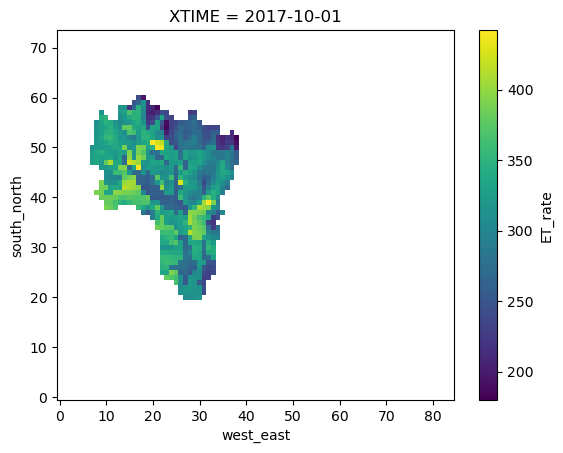

In [104]:
et_yearly = et_monthly.sum(dim='XTIME')
et_yearly['ET_rate'].where(wy2018_wrf_ds.isel(XTIME=0).EAST_MASK==True).plot.imshow()

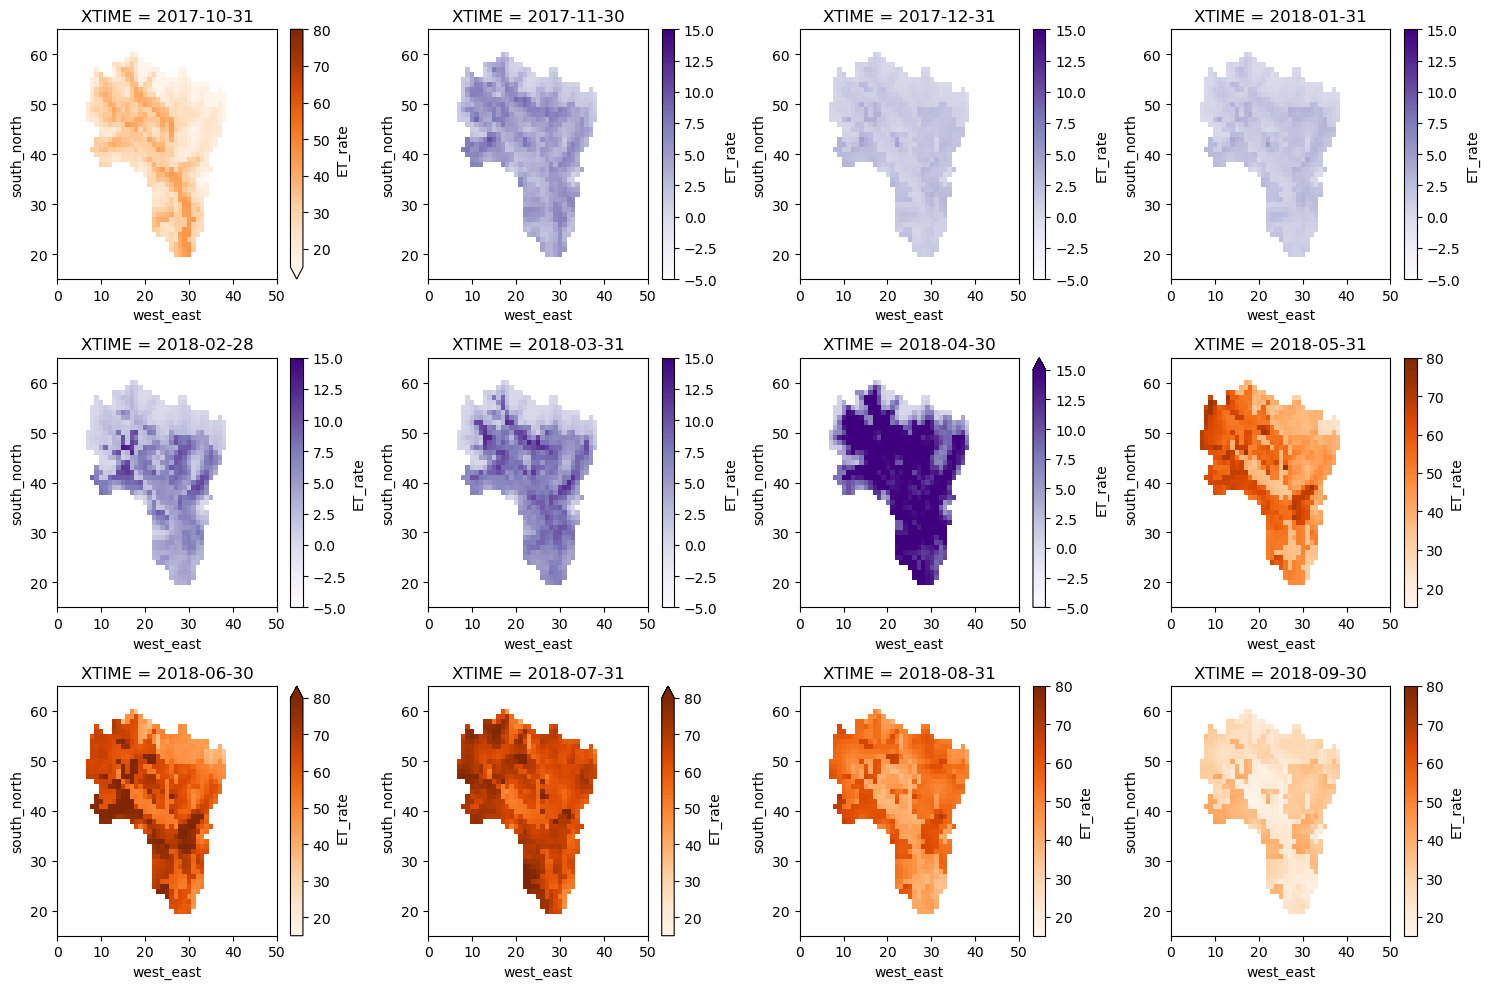

In [98]:
fig, axs = plt.subplots(3,4, figsize=(15,10), tight_layout=True)
axs = axs.ravel()
for i,ax in enumerate(axs):
    if i in [1,2,3,4,5,6]:
        et_monthly.ET_rate.where(wy2018_wrf_ds.EAST_MASK==True).isel(XTIME=i).compute().plot.imshow(ax=ax, cmap='Purples', vmin=-5, vmax=15)
    else:
        et_monthly.ET_rate.where(wy2018_wrf_ds.EAST_MASK==True).isel(XTIME=i).compute().plot.imshow(ax=ax, cmap='Oranges', vmin=15, vmax=80)
    ax.set_xlim(0,50)
    ax.set_ylim(15,65)